In [1]:
import sys
print(sys.executable)


/opt/anaconda3/envs/COMP647_env_py312/bin/python


- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 02/09/2025

# Project Plan

- Columns to keep or drop
    - Columns to keep are: "uniq_id", "product_name", "price", "number_available_in_stock", "number_of_reviews", "average_review_rating", "amazon_category_and_sub_category", "product_information", "customer_reviews" and "seller".
    - I will drop "manufacturer" because it contains too much random and inaccurate information, such as numbers or repeated words from the product name, which makes it impossible to clean. 
    - I will drop "number_of_answered_questions" since the numbers don’t give any meaningful insight (the actual questions are unknown).
    - I will drop "customers_who_bought_this_item_also_bought" and "items_customers_buy_after_viewing_this_item" because they only contain product web links, and most of them are likely invalid as the dataset is quite old.
    - I will drop "description" and "product_description" because they are long paragraphs with similar content, and it is hard to extract clear, representative keywords from them.
    - I will drop "customer_questions_and_answers" because only 914 out of 10,000 rows are filled, and the filled ones contain long paragraphs that are difficult to handle.

- Clean data 
    - For "price", remove symbols before the number.
    - For "number_available_in_stock", split into two columns: "stock_quantity" and "stock_status".
    - From "average_review_rating", extract the numeric part into a new column called "average_rating".
    - For "amazon_category_and_sub_category", split into two levels only, and label them "main_category" and "sub_category".
    - From "product_information", extract product weight (e.g., values like weight…g or weight…kg) into a new column called "product_weight".
    - For "product_weight":
        - extract only numbers and g/kg,
        - convert all g values into kg,
        - remove the unit (e.g., kg).
    - From "product_information", also extract age suitability (e.g., age…up) into a new column called "age_suitability", and keep only the numeric part.
    - From "customer_reviews", extract the first date into a new column called "purchase_date" (assuming reviews were made in the same month as purchase).
    - From "seller", extract only the seller name.
    - Fix the data type for each feature.
    - For all string columns, use .strip() to remove leading and trailing spaces.
    - Drop the original features after transformation.


- Transform data
    - Filling missing value
        - For categories, use "Unknown main category" and "Unknown sub category".
        - For "price", fill with the average price of the same sub_category.
        - For "stock_quantity", fill with the mode of the same sub_category.
        - For "stock_status", fill with the mode of the same sub_category.
        - For "product_weight", fill with the median of the same sub_category.
        - For "age_suitability", fill with the mode of the same sub_category.
        - For "purchase_date", fill with the mode of the same sub_category.
        - For "number_of_reviews", fill with the mode of the same sub_category.
        - For "average_rating", fill with the average rating of the same sub_category.
        - For "seller", fill with "Unknown seller".


- Visualise data
    - Filter data to only:
        - number_of_reviews>=51
        - average rating>=4.5
    - Produce a scatter plot where x="number_of_reviews" y="average rating" and hue="top category"

# Research Question

As an entrepreneur, I want to know:
- Which main product category tends to receive a higher response rate and higher ratings? (if I assume that higher product ratings correspond to better sales performance)
- Which sub category within that main category has a higher response rate and higher ratings?
- Which seller has most products to sell?
- Which main category product is receiving has highest ratings and doesn't cost that much for stocking?
- What is the item quantity I should at least prepare?

As a buyer, I want to know:
- For the same product, which seller is selling at a cheaper price?
- Which seller received more high ratings for their product?

As the company, I want to know:
- Which month of the year made most sale?
- Compare sales across the years to discover which year made the highest gross profit and mainly from which category of products?

# Import the Necessary Libraries for Data Cleaning

In [2]:
import numpy as np # Numerical operations and array handling.
import pandas as pd # Data manipulation and analysis.
import matplotlib.pyplot as plt # Plotting library for creating static, animated, and interactive visualizations.
import seaborn as sns # Statistical data visualization library based on matplotlib.
from scipy import stats # Module for scientific computing, including statistical functions.
import re # Regular expressions for string matching and manipulation.


# Read Data from CSV

Data source: [Fashion products on Amazon.com](https://www.kaggle.com/datasets/hkhamnakhalid/fashion-products-on-amazoncom)

In [3]:
file_path = 'amazon_co-ecommerce_sample.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path) # Read the csv file into a DataFrame.

# Understand Data

In [4]:
df[df.groupby('product_name')['product_name'].transform('count') > 1] 
# The .groupby function allows to aggregate the data occurance. 
# The .transform('count') > 1 will call out data under the product name occur more than once.
# The intention of this move

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
71,1e9876e6f7e98a6bb869341b4b56efd5,Power Trains Auto Loader City,POWER CITY TRAINS,£76.99,2 new,NaN,1.0,NaN,NaN,http://www.amazon.co.uk/Power-Trains-Auto-Load...,Power City Trains Auto Loader City,Technical Details Item Weight1.5 Kg Product Di...,Power City Trains Auto Loader City,http://www.amazon.co.uk/Power-Trains-Auto-Load...,NaN,NaN,"{""seller""=>[{""Seller_name_1""=>""Eurozone Market..."
411,b585918cbbf998a288bbb259313f0296,Polyhedral Dice,Chessex,£11.93,4 new,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/Polyhedral,Signature dice are a compilation of the best s...,Technical Details Item Weight54 g Product Dime...,Signature dice are a compilation of the best s...,NaN,NaN,RPG-tastic! // 5.0 // 21 April 2013 // By\n ...,NaN
441,47e284cab850f3a73f412ed5fe85d969,"100 six sided dice, 14mm, random colours",The Dice Place,£10.79,NaN,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/Chessex-Dice-Pound-Pou...,A pack of 100 (minimum) dice useful for many b...,Technical Details Item Weight277 g Product Dim...,A pack of 100 (minimum) dice useful for many b...,http://www.amazon.co.uk/sided-dice-16mm-random...,NaN,Five Stars // 5.0 // 19 Feb. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""Legendgames"", ""S..."
471,b5b9d9641ddd0c677c5ddaa719207f63,Polyhedral Dice,Chessex,£9.74,2 new,1,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/WHATWEARS-Poly-Dices-P...,NaN,Technical Details Item Weight54 g Manufacturer...,NaN,NaN,NaN,"Good design and good quality, would recommend....",NaN
585,222285fb1f28be6b3d6d14d5c35e562f,"100 six sided dice, 14mm, random colours",The Dice Place,£10.79,NaN,2,1.0,5.0 out of 5 stars,Games > Dice & Dice Games,http://www.amazon.co.uk/spot-12mm-diameter-ass...,A pack of 100 (minimum) dice useful for many b...,Technical Details Item Weight277 g Product Dim...,A pack of 100 (minimum) dice useful for many b...,http://www.amazon.co.uk/spot-12mm-diameter-ass...,NaN,I now have want more // 5.0 // 7 Mar. 2013 // ...,"{""seller""=>{""Seller_name_1""=>""Legendgames"", ""S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,0046d3f852f55ee28b4a049ed387a946,Orchard Toys Farmyard Dominoes,Orchard Toys,£7.99,21 new,19,5.0,4.8 out of 5 stars,Games > Educational Games,http://www.amazon.co.uk/Orchard-Toys-28-Farm-S...,Product Description This is the familiar game ...,Technical Details Item Weight572 g Product Dim...,Product Description This is the familiar game ...,http://www.amazon.co.uk/Orchard-Toys-Old-MacDo...,NaN,brilliant // 5.0 // 15 May 2012 // By\n \n ...,"{""seller""=>[{""Seller_name_1""=>""Atrad"", ""Seller..."
9449,0cf2e89e32c4729f71647e876cbb5dec,20Q,Mattel,NaN,NaN,34,1.0,4.4 out of 5 stars,Electronic Toys > Educational Computers & Acce...,http://www.amazon.co.uk/An-Astronauts | http:/...,Product Description I have mixed the bar-codes...,Technical Details Item Weight222 g Product Dim...,Product Description I have mixed the bar-codes...,http://www.amazon.co.uk/Radica-I4012-20Q/dp/B0...,does the ball talk? // No displays answer on s...,I beg to differ // 4.0 // 27 Oct. 2010 // By\n...,NaN
9467,b7fb4625845f84ffc5b34fdc27189587,20Q,Radica,NaN,2 new,102,1.0,4.5 out of 5 stars,Games > Trivia & Quiz Games,http://www.amazon.co.uk/Radica-I6088-20Q-Versi...,Product Description I can read your mind! Manu...,Technical Details Item Weight91 g Product Dime...,Product Description I can read your mind! Manu...,http://www.amazon.co.uk/Radica-I6088-20Q-Versi...,NaN,"Great, but a little bit spooky!! // 5.0 // 21 ...","{""seller""=>[{""Seller_name_1""=>""Smaller Worl

In [5]:
# Use DataWrangler to understand data quality issues. 
# This extension helps to identify missing values, duplicates, and other data quality issues by providing a summary and displaying data in a table format.
df.head(1)

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."


# Keep Useful Columns Only

### All Columns in DataFrame

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      10000 non-null  object 
 1   product_name                                 10000 non-null  object 
 2   manufacturer                                 9993 non-null   object 
 3   price                                        8565 non-null   object 
 4   number_available_in_stock                    7500 non-null   object 
 5   number_of_reviews                            9982 non-null   object 
 6   number_of_answered_questions                 9235 non-null   float64
 7   average_review_rating                        9982 non-null   object 
 8   amazon_category_and_sub_category             9310 non-null   object 
 9   customers_who_bought_this_item_also_bought   8938 non-null   object 
 10 

### All Columns in Cleaned DataFrame

In [7]:
cleaned_df=df[[
    'uniq_id',
    'product_name',
    'price',
    'number_available_in_stock',
    'number_of_reviews',
    'average_review_rating',
    'amazon_category_and_sub_category',
    'product_information',
    'customer_reviews',
    'sellers']]

In [8]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   uniq_id                           10000 non-null  object
 1   product_name                      10000 non-null  object
 2   price                             8565 non-null   object
 3   number_available_in_stock         7500 non-null   object
 4   number_of_reviews                 9982 non-null   object
 5   average_review_rating             9982 non-null   object
 6   amazon_category_and_sub_category  9310 non-null   object
 7   product_information               9942 non-null   object
 8   customer_reviews                  9979 non-null   object
 9   sellers                           6918 non-null   object
dtypes: object(10)
memory usage: 781.4+ KB


# Reformat Columns

## Remove Symbols in "price" Column

In [9]:
# Although it is obvious that this column contains money symbol, but it could also contain other characters that I oversee. 
# So, instead of droping the things I don't want, I will extract the things I want.

cleaned_df['cleaned_price'] = (
    cleaned_df['price']
    .astype(str)  # change the datatype to string
    .str.extract(r'(\d+\.\d+|\d+)')  # From the string, extract only the numeric vaules using regular expression
    #(r'\d+\.\d+|\d+') this regex pattern matches both integer and decimal numbers.
    .astype(float) )

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/2785400651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['cleaned_price'] = (


In [10]:
cleaned_df.info()
cleaned_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
dtypes: float64(1), object(10)
memory usage: 859.5+ KB


,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99


## Split values in "number_available_in_stock" Column

In [11]:
# This column contains both integer and string values. I will first extract the integer values, then convert them to numeric datatype.

cleaned_df['stock_quantity'] = (
    cleaned_df['number_available_in_stock']
    .str.extract(r'(\d+)')   # Using the regular expression (r'\d+') to capture the integer numbers.
    .astype('Int64')) # I tried using 'int', but it didn't work because 'int' can only be used when there are no missing values or NaN. 
    # So, I used 'Int64' instead, and it worked. 'Int64' can handle the presence of missing value and NaN values.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/2153675905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['stock_quantity'] = (


In [12]:
# After extracting the numerical values, I will extract the string values to another new column.

cleaned_df['stock_condition'] = (
    cleaned_df['number_available_in_stock']
    .str.extract(r'\d+\s*(.*)')[0]  
    #  \d+ represents any digit before the space.
    #  \s* represents any space between the digit and the string.
    #  (.*) extract everything after the space, which is the string part.
    .str.strip()) 


/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/741352323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['stock_condition'] = (


In [13]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

## Extract Numerical Data from "average_review_rating" and Correct Data Type

In [14]:
cleaned_df['average_review_rating_out_of_5'] = (# Create a new column 'average_rating_out_of_5.0' in cleaned_df for cleaned average review ratings.
    cleaned_df['average_review_rating'] 
    .astype(str) # Convert to string to handle any NaNs, as explained in the previous steps.
    .str.extract(r'(\d+\.\d+|\d+)', expand=False)  
    # (\d+ extracts one or more digits. Eg: '123', '4567', '89'.
    # \.\d+ extracts a decimal point followed by one or more digits. Eg: '3.5', '4.0', '2.75'.
    # | extracts ither an integer (\d+) or a float (\d+\.\d+).
    # expand=False ensures that the result is a Series, not a DataFrame. Eg: '123.45' will be extracted as a single value, not as 1, 2, 3 . 4 and 5 in individual columns.
    .astype(float)
 ) # Convert to float.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/3933719750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['average_review_rating_out_of_5'] = (# Create a new column 'average_rating_out_of_5.0' in cleaned_df for cleaned average review ratings.


In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

## Split Product Hierachy for "amazon_category_and_sub_category" Column


In [16]:
# The reason to keep two levels of the hierachy only is because many of the category level stopped after two levels. 

cleaned_df[['main_category', 'sub_category']] = (
    df['amazon_category_and_sub_category']
    .str.split('>', expand=True)[[0, 1]])
# The .str.split('>') function splits the string into a list of substrings based on the '>'.
# The expand=True function specifies the split data to expand to its new column, not within the original column. 
# The [[0,1]] function specifies to select the first and second from the hierachy list only.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/127122190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[['main_category', 'sub_category']] = (
/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/127122190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[['main_category', 'sub_category']] = (


In [17]:
cleaned_df.info()
# The row count of the two new columns are same as the original. This means good.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [18]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets


In [19]:
print(cleaned_df['main_category'].value_counts(dropna=False)) 
# This function allows me to see the count of each category, including the missing value.

main_category
Hobbies                              1464
Die-Cast & Toy Vehicles              1221
Figures & Playsets                   1111
Characters & Brands                   960
Games                                 941
Arts & Crafts                         802
Party Supplies                        694
NaN                                   690
Fancy Dress                           585
Sports Toys & Outdoor                 372
Dolls & Accessories                   371
Jigsaws & Puzzles                     274
Puppets & Puppet Theatres             269
Baby & Toddler Toys                   106
Pretend Play                           45
Musical Toy Instruments                19
Novelty & Special Use                  11
Pens, Pencils & Writing Supplies        7
Office Supplies                         6
Electronic Toys                         5
Home Accessories                        5
Bags                                    4
Cooking & Dining                        4
Educational Toys    

In [20]:
print(cleaned_df['sub_category'].value_counts(dropna=False)) 

sub_category
 Toy Vehicles & Accessories          1100
NaN                                   690
 Science Fiction & Fantasy            485
 Accessories                          388
 Model Trains & Railway Sets          386
                                     ... 
 Transportation & Traffic               1
 Specialty & Decorative Lighting        1
 Instruments                            1
 Trading Cards & Accessories            1
 Drinking Games                         1
Name: count, Length: 166, dtype: int64


## Extract Values from "product_information" Column

### Extract Item Weight

In [21]:
# This column has a lot of mixed information, but I only want to extract two things. They are the item weight (for logistics) and the recommended age (for buyer reference).

cleaned_df['item_weight'] = cleaned_df['product_information'].str.extract(r'Item Weight\s*([\d\.]+\s*(?:g|Kg))', 
    expand=False)

# Regular expression is used to exract the item weight, with \s* allows for space between the word item and weight.
# ([\d\.]+ specifies extracting value with one or more digits or decimal point.
# \s* allows for space after the value.
# (?:g|Kg) specifies the unit can either be g or kg.
# The entire expression within the bracket indicates to only return the weight value plus unit.

In [22]:
# I want the unit within the column to be consistent for better data reviewing. 

def convert_to_kg(value): # This def instruction defines what I want python to do with "convert_to_kg".
    if pd.isna(value):  # if value is missing, just return NaN
        return None
    value = value.strip() 
    if value.endswith("Kg"): # if values end with kg
        return float(value.replace("Kg", "").strip()) # return only a decimal value and replace the kg with whitespace.
    elif value.endswith("g"): # if values ends with g
        return float(value.replace("g", "").strip()) / 1000 # return only a decimal value that divided by 1000 and replace the g with whitespace.
    else:
        return None
    
cleaned_df['item_weight'] = cleaned_df['item_weight'].apply(convert_to_kg)
# By applying the defined instruction that has been explained to python, I want it to apply this expression to the "item_weight" column to remove the unit and make everything numeric in kilograms.

In [23]:
# Rename the column to reflect the unit.
cleaned_df.rename(columns={'item_weight': 'item_weight_in_kg'}, inplace=True)

In [24]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets,NaN
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,NaN


### Extract Recommended Age

In [25]:
# First, extract the manufacturer recommended age from the product_information column.

age_extracted = cleaned_df['product_information'].str.extract(
    r'Manufacturer recommended age:(\d+)\s*(years|months)',
    expand=True)  


In [26]:
age_value = pd.to_numeric(age_extracted[0], errors='coerce')
age_unit = age_extracted[1]

In [27]:
cleaned_df['recommended_minimum_age_years'] = np.where(
    age_unit == 'months',
    age_value / 12,   # months → years
    age_value).round(2)  # already in years


In [28]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",16.99,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets,NaN,3.0
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,NaN,3.0


## Extract Date from "customer_reviews"

In [29]:
# This dataset doesn't have a purchase date column. 
# So I will extract the first date from the customer_reviews to simulate the purchase date, as assuming the the review is within a month of the purchase.

date_extract = cleaned_df['customer_reviews'].str.extract(r'\b(?:[1-9]|[12][0-9]|3[01])\s+([A-Za-z]+)\.?\s+(\d{4})')

# \b represents a boundry of a word or number to ensure that we are matching the day at the start of the date.
# (?:[1-9]|[12][0-9]|3[01]) represents matching day values from 1 to 31.
# \s represents space and the + represents one or more.
# ([A-Za-z]+\.?) represents month. Extracting either 'Nov.' or 'April'.
# (\d{4}) represents year in four digits.

In [30]:
# Allocating the extracted month and year to two new columns and standardising the month column.

cleaned_df['purchase_month'] = date_extract[0] # Capture month first to a new column.
cleaned_df['purchase_month'] = cleaned_df['purchase_month'].str.replace(r'\.', '', regex=True) 
# Remove any dots like in 'Nov.' to make it 'Nov'.

month_map = {
    'January': 'Jan', 'Jan': 'Jan',
    'February': 'Feb', 'Feb': 'Feb',
    'March': 'Mar', 'Mar': 'Mar',
    'April': 'Apr', 'Apr': 'Apr',
    'May': 'May',
    'June': 'Jun', 'Jun': 'Jun',
    'July': 'Jul', 'Jul': 'Jul',
    'August': 'Aug', 'Aug': 'Aug',
    'September': 'Sep', 'Sept': 'Sep', 'Sep': 'Sep',
    'October': 'Oct', 'Oct': 'Oct',
    'November': 'Nov', 'Nov': 'Nov',
    'December': 'Dec', 'Dec': 'Dec'}

cleaned_df['purchase_month'] = cleaned_df['purchase_month'].map(month_map)


cleaned_df['purchase_year'] = date_extract[1].astype('Int64') # Capture year subsequently to another new column.

In [31]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [32]:
print(cleaned_df['purchase_month'].unique())

# I noticed that that the extracted month row count is 9278, less than the customer_reviews row count. 
# However, the purchase_year row count is the same as the customer_reviews row count.
# So, I want to check the unique values in the purchase_month column to see what is there.

['Apr' 'Dec' 'May' 'Jul' 'Oct' 'Jan' 'Nov' 'Feb' 'Aug' 'Mar' 'Jun' 'Sep'
 nan]


In [33]:
missing_months = cleaned_df[cleaned_df['purchase_year'].notna() & cleaned_df['purchase_month'].isna()]
# The .notna() function checks for non-missing values in the purchase_year column.
# The .isna() function checks for missing values in the purchase_month column.

# This function demonstrates which rows had the year but no month extracted.
# From this I saw that some months were recorded in a weird format like Sept, while others are like Sep or September, causing confusion to the regex extraction.
# I fixed the month mapping above, then I re-run the code and the row count was 9978. However, this is still one less than the customer_reviews row count of 9979.
# The issue was that in one of the rows, there was a 4-digit number just before the day, month and year, causing the regex to confuse and fail extract this row.
# I fixed the issue by going back to step 1 to alter the regex to be even more flexible.

print(missing_months['customer_reviews'].head(20))

Series([], Name: customer_reviews, dtype: object)


## Extract Seller Name from "sellers" Column

In [34]:
cleaned_df['seller_name'] = (
    cleaned_df['sellers']
    .str.extract(r'"Seller_name_1"=>\"([^"]+)"'))  
# "Seller_name_1"=>\", this part is how the data was structured in the original column. Within this regex, it means find the data after this pattern.
# The ([^"]+) means capture everything between the quotes.

In [35]:
def clean_seller_name(name):
    if pd.isna(name):
        return name
    # 1. Remove text in parentheses.
    name = re.sub(r"\(.*?\)", "", name) # remove (...) blocks
    name = re.sub(r'\s*\[.*?\]', '', name) # remove [...] blocks
    
    # 2. Remove text after symbols.
    name = re.split(r'\s*[-–—]{1,2}\s*', name)[0] # Remove text after " — " or " -- " or " --- "
    name = re.split(r'[|*]', name)[0] # Remove text after | or *
    return name.strip()

In [36]:
# After reviewing the data manually, I noticed some seller names have a very different pattern. 
# The name and extra information like advertisement, logistics, etc are not separated by any punctuations or symbols.
# So, the Heuristic trimming is used to remove any text following the presence of the listed stop words.

stop_words = ["free", "uk", "delivery", "dispatch", "ship", "supply", 
              "days", "arrive", "ignore", "estimates", "order", "p&p", 
              "authorised", "mainland", "seller"]


In [37]:
def heuristic_trim(name):
    words = name.split()
    cleaned = []
    for w in words: # Go through each word in the name that has been split in prior step.
        if w.lower() in stop_words: # Convert the word to lowercase so that it is not case sensitive during matching. If a stop word is found,
            break # Cut off the rest of the text.
        cleaned.append(w) # If the word is not a stop word, keep it.
    return " ".join(cleaned).strip() # Join back the split cleaned words as the seller name.

cleaned_df['seller_name'] = cleaned_df['seller_name'].astype(str).apply(lambda x: heuristic_trim(clean_seller_name(x)))

In [38]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [39]:
cleaned_df.head(3)

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,average_review_rating,amazon_category_and_sub_category,product_information,customer_reviews,sellers,...,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,£3.42,5 new,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Item Weight640 g Product Dim...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",...,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,Apr,2014,Amazon.co.uk
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,£16.99,NaN,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...",...,<NA>,NaN,4.5,Hobbies,Model Trains & Railway Sets,NaN,3.0,Dec,2015,UHD WHOLESALE
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,£9.99,2 new,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Technical Details Manufacturer recommended age...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...",...,2,new,3.9,Hobbies,Model Trains & Railway Sets,NaN,3.0,May,2015,DEAL


## Apply Strip () to All Str Type Columns

In [40]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uniq_id                           10000 non-null  object 
 1   product_name                      10000 non-null  object 
 2   price                             8565 non-null   object 
 3   number_available_in_stock         7500 non-null   object 
 4   number_of_reviews                 9982 non-null   object 
 5   average_review_rating             9982 non-null   object 
 6   amazon_category_and_sub_category  9310 non-null   object 
 7   product_information               9942 non-null   object 
 8   customer_reviews                  9979 non-null   object 
 9   sellers                           6918 non-null   object 
 10  cleaned_price                     8565 non-null   float64
 11  stock_quantity                    7500 non-null   Int64  
 12  stock

In [41]:
for col in cleaned_df.select_dtypes(include='object').columns:
    cleaned_df[col] = cleaned_df[col].str.strip()

## Drop Original Columns

In [42]:
cleaned_df.drop(columns=['price','number_available_in_stock','average_review_rating',
                         'amazon_category_and_sub_category','product_information','customer_reviews','sellers'], inplace=True)  
# Drop the original column after extracting the main category.

In [43]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   number_of_reviews               9982 non-null   object 
 3   cleaned_price                   8565 non-null   float64
 4   stock_quantity                  7500 non-null   Int64  
 5   stock_condition                 7500 non-null   object 
 6   average_review_rating_out_of_5  9982 non-null   float64
 7   main_category                   9310 non-null   object 
 8   sub_category                    9310 non-null   object 
 9   item_weight_in_kg               7752 non-null   float64
 10  recommended_minimum_age_years   8718 non-null   float64
 11  purchase_month                  9979 non-null   object 
 12  purchase_year                   9

# Filling Missing Values

## Fill in 'main_category'

In [44]:
cleaned_df['main_category'] = cleaned_df['main_category'].fillna('Unknown') # fillna() replaces NaN values with 'Unknown'.

## Fill in 'sub_ategory'

In [45]:
cleaned_df['sub_category'] = cleaned_df['sub_category'].fillna('Unknown') # fillna() replaces NaN values with 'Unknown'.

In [46]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,Apr,2014,Amazon.co.uk


## Fill in 'price'

In [47]:
cleaned_df['cleaned_price'] = (
    cleaned_df.groupby('sub_category')['cleaned_price']
    .transform(lambda x: x.fillna(x.mean()))).round(2)
# I group the sub_category with the cleaned_price to fill in the missing values using the average price of the same sub_category.
# However, I discovered that there are 2 rows with missing value. 
# These two rows contains numerous other missing values, thus I decide to drop these two rows later. 


In [48]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,Apr,2014,Amazon.co.uk


## Fill in 'stock_quantity'

In [49]:
# I initially tried to fill in using the (x.mode()), but it didnt work because it returned a series of frequent values, which is missing value. So the missing values remain missing.
# Then, I also discovered that some sub_categories only contain missing values.
# So, I decided that if the sub_category cannot be used to provide a mode value, then I will go up a level, use the main_category to fill in the missing values.

# Capture the mode values from each sub_category.
subcat_modes = (
    cleaned_df.groupby('sub_category')['stock_quantity']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))
# .agg(lambda x:...) represents aggregating a small function to a group.
# x.mode() find the mode.
# .iloc[0] choose the first mode if there are multiple modes.
# if not x.mode().empty else None, this is when all the values in the group are missing, then return None.

In [50]:
# Capture the mode values from main_category.
maincat_modes = (
    cleaned_df.groupby('main_category')['stock_quantity']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

In [51]:
# Define a function for python to run.

def fill_with_mode(row):
    if pd.notna(row['stock_quantity']): # If the value is not NaN, then return as it is.
        return row['stock_quantity']
   
    # First, try fill in using the mode from sub_category.
    sub_mode = subcat_modes.get(row['sub_category'], None)
    if pd.notna(sub_mode):
        return sub_mode
    
    # When filling in mode values using sub_category fail, then use main_category to fill in.
    main_mode = maincat_modes.get(row['main_category'], None)
    if pd.notna(main_mode):
        return main_mode
   
    # If even that fails, just keep it NaN
    return np.nan


In [52]:
cleaned_df['stock_quantity'] = cleaned_df.apply(fill_with_mode, axis=1).astype('Int64')
# Apply the defined function.
# axis=1 means apply the function to row, while axis=0 means apply the function to column.

In [53]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,Apr,2014,Amazon.co.uk


## Fill in 'stock_condition'

In [54]:
subcat_modes = (
    cleaned_df.groupby('sub_category')['stock_condition']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

In [55]:
maincat_modes = (
    cleaned_df.groupby('main_category')['stock_condition']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

In [56]:
def fill_with_mode(row):
    if pd.notna(row['stock_condition']): # If the value is not NaN, then return as it is.
        return row['stock_condition']
   
    # First, try fill in using the mode from sub_category.
    sub_mode = subcat_modes.get(row['sub_category'], None)
    if pd.notna(sub_mode):
        return sub_mode
    
    # When filling in mode values using sub_category fail, then use main_category to fill in.
    main_mode = maincat_modes.get(row['main_category'], None)
    if pd.notna(main_mode):
        return main_mode
   
    # If even that fails, just keep it NaN
    return np.nan


cleaned_df['stock_condition'] = cleaned_df.apply(fill_with_mode, axis=1)

In [57]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   number_of_reviews               9982 non-null   object 
 3   cleaned_price                   9989 non-null   float64
 4   stock_quantity                  9996 non-null   Int64  
 5   stock_condition                 9996 non-null   object 
 6   average_review_rating_out_of_5  9982 non-null   float64
 7   main_category                   10000 non-null  object 
 8   sub_category                    10000 non-null  object 
 9   item_weight_in_kg               7752 non-null   float64
 10  recommended_minimum_age_years   8718 non-null   float64
 11  purchase_month                  9979 non-null   object 
 12  purchase_year                   9

In [58]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.64,6.0,Apr,2014,Amazon.co.uk


## Fill in 'item_weight_in_kg'

In [59]:
# The reason to fill in the missing value using the median is because weight data is often skewed.
# So, if I use either mean or mode, will result in biased values.

cleaned_df['item_weight_in_kg'] = (
    cleaned_df.groupby('sub_category')['item_weight_in_kg']
    .transform(lambda x: x.fillna(x.median())))

In [60]:
# Missing values still exist after filling in using sub_category median.
# Since moving up a level to main_category can cause too much vairations, I won't do that.
# Instead, I will fill in the remainders with 0.0

cleaned_df['item_weight_in_kg'] = cleaned_df['item_weight_in_kg'].fillna(0.0).round(1)

In [61]:
cleaned_df.head(3)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,Apr,2014,Amazon.co.uk
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,Dec,2015,UHD WHOLESALE
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,17,9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,0.2,3.0,May,2015,DEAL


## Fill in 'average_review_rating_out_of_5'

In [62]:
cleaned_df['average_review_rating_out_of_5'] = (
    cleaned_df.groupby('sub_category')['average_review_rating_out_of_5'] # .groupby() groups the DataFrame by 'amazon_category'and 'average_review_rating_out_of_5' columns.
    .transform(lambda x: x.fillna(x.mean()))).round(1) # .transform() applies a function to each group, filling NaN values with the mean of the group.
    # lambda x: x.fillna(x.mean()) calculates the mean of the group and fills NaN values with that mean.

In [63]:
cleaned_df.head(1)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,Apr,2014,Amazon.co.uk


## Fill in 'recommended_minimum_age_years'

In [64]:
# I learned that it is a good idea to use 2 levels fallback to fill in missing values.
# So, I will use this approach for this column as well.

# Calculate the modes for both levels.
sub_modes = cleaned_df.groupby("sub_category")["recommended_minimum_age_years"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
main_modes = cleaned_df.groupby("main_category")["recommended_minimum_age_years"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)

In [65]:
# Firstly, try to fill in using the sub_category mode.
cleaned_df['recommended_minimum_age_years'] = (
    cleaned_df.groupby('sub_category')['recommended_minimum_age_years']
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x)))

In [66]:
# When the sub_category doesn't work out, then use main_category as fallback.
cleaned_df["recommended_minimum_age_years"] = cleaned_df.apply(
    lambda row: main_modes[row["main_category"]]
    if pd.isna(row["recommended_minimum_age_years"]) and pd.notna(main_modes[row["main_category"]])
    else row["recommended_minimum_age_years"],axis=1)

In [67]:
# I realised that even after 2 levels of fallback, there are still some missing values.
# So, I am creating another level of fallback to fill in the missing values with 0.0, as some products may not have a recommended age.
# Moreover, 0.0 exists in the original data, as some products are recommeded for 0 month and up.

cleaned_df["recommended_minimum_age_years"] = cleaned_df["recommended_minimum_age_years"].fillna(0.0)

In [68]:
cleaned_df.head(3)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,Apr,2014,Amazon.co.uk
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,Dec,2015,UHD WHOLESALE
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,17,9.99,2,new,3.9,Hobbies,Model Trains & Railway Sets,0.2,3.0,May,2015,DEAL


## Fill in 'number_of_reviews'

In [69]:
cleaned_df['number_of_reviews'] = pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce')
# pd.to_numeric() converts values to numbers, and anything invalid (like strings or symbols) becomes NaN.
# errors='coerce' ensures that any non-numeric values are converted to NaN instead of raising an error.

In [70]:
cleaned_df['number_of_reviews'] = (
    cleaned_df.groupby('sub_category')['number_of_reviews']
    .transform(lambda x: x.fillna(x.mode())))
    # .transform() applies a function to each categorical group, filling NaN values with the mode of the group.
    # lambda x: x.fillna(x.mode()) calculates the mode of the group and fills NaN values with that mode.

In [71]:
# Missing values still exist due to complete lack of data within the sub_category.
# Maybe those certain products within the same sub_category just tend to not be reviewed.
# So, I will fill in with 0.
cleaned_df['number_of_reviews'] = cleaned_df['number_of_reviews'].fillna(0).astype('Int64')

In [72]:
print(cleaned_df.isna().sum())
cleaned_df.head(1)

uniq_id                            0
product_name                       0
number_of_reviews                  0
cleaned_price                     11
stock_quantity                     4
stock_condition                    4
average_review_rating_out_of_5     0
main_category                      0
sub_category                       0
item_weight_in_kg                  0
recommended_minimum_age_years      0
purchase_month                    21
purchase_year                     21
seller_name                        0
dtype: int64


,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,Apr,2014,Amazon.co.uk


## Fill in 'purchase_year'

In [73]:
# Some of the transaction years are missing.
# I decided to fill in using the most frequent transaction year of the respective seller, because the transaction year is more likely to occur during the active period of the seller.

seller_modes = cleaned_df.groupby("seller_name")["purchase_year"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
# Using .iloc[0] to capture first interger location for the mode value.

In [74]:
cleaned_df["purchase_year"] = cleaned_df.apply(
    lambda row: seller_modes[row["seller_name"]]
    if pd.isna(row["purchase_year"]) and pd.notna(seller_modes[row["seller_name"]])
    else row["purchase_year"],axis=1).astype('Int64')

In [75]:
cleaned_df.info()
cleaned_df.head(1)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         10000 non-null  object 
 1   product_name                    10000 non-null  object 
 2   number_of_reviews               10000 non-null  Int64  
 3   cleaned_price                   9989 non-null   float64
 4   stock_quantity                  9996 non-null   Int64  
 5   stock_condition                 9996 non-null   object 
 6   average_review_rating_out_of_5  10000 non-null  float64
 7   main_category                   10000 non-null  object 
 8   sub_category                    10000 non-null  object 
 9   item_weight_in_kg               10000 non-null  float64
 10  recommended_minimum_age_years   10000 non-null  float64
 11  purchase_month                  9979 non-null   object 
 12  purchase_year                   9

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,Apr,2014,Amazon.co.uk


## Fill in 'purchase_month'

In [76]:
def fill_with_mode(x):
    mode_val = x.mode()
    return x.fillna(mode_val.iloc[0] if not mode_val.empty else x)

cleaned_df['purchase_month'] = (
    cleaned_df.groupby(['seller_name', 'purchase_year'])['purchase_month']
    .transform(fill_with_mode))

In [77]:
print(cleaned_df.isna().sum())
cleaned_df.head(1)

uniq_id                            0
product_name                       0
number_of_reviews                  0
cleaned_price                     11
stock_quantity                     4
stock_condition                    4
average_review_rating_out_of_5     0
main_category                      0
sub_category                       0
item_weight_in_kg                  0
recommended_minimum_age_years      0
purchase_month                     3
purchase_year                      3
seller_name                        0
dtype: int64


,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,Apr,2014,Amazon.co.uk


## Fill in 'seller_name'

In [78]:
print(cleaned_df.isna().sum())

uniq_id                            0
product_name                       0
number_of_reviews                  0
cleaned_price                     11
stock_quantity                     4
stock_condition                    4
average_review_rating_out_of_5     0
main_category                      0
sub_category                       0
item_weight_in_kg                  0
recommended_minimum_age_years      0
purchase_month                     3
purchase_year                      3
seller_name                        0
dtype: int64


## Drop Rows with Too Many Missing Values

In [79]:
# Drop a row from 'cleaned_price' using the approach of drop the row with missing value under 'cleaned_price'.
# This row is lacking in too many data, hindering the price value to be filled. 

cleaned_df = cleaned_df.dropna(subset=["cleaned_price"])

In [80]:
# Drop three rows using the ID matching approach under 'uniq_id'.
# The reason for dropping these rows is because they lack of many other data and most importantly, the seller only appeared once in the entire dataset.
# Therefore, it is impossible to fill in the missing values using the seller's mode values or pairing with other columns, as many data are also missing. 

bad_ids = [
    "1a6e96685344f84c012c1b3576498847",
    "5c49ba4580a25eb9c72094f5eb1c347b",
    "7f1fc90d8a23ecf28e3206269e06e8d9"]

cleaned_df = cleaned_df[~cleaned_df['uniq_id'].isin(bad_ids)]

In [81]:
# I also decided to drop these three rows as the stock_quantity, stock_condition and item_weight_in_kg cannot be filled using any approach.
# The type of main and sub categories they fall under only occurred once in the entire dataset.
# The seller also only sold this one product in the entire dataset.
# The transaction price of these three products ranged from 1.99 to 13.99, not like it made a significant profit or made a huge contribution to the overall sales.
# So, I believe dropping them doesn't impact the data anlysis substantially.

bad_ids = [
    "3a95fd1bb2148e1f353b548774ad315f",
    "11f5fece1e9b0d7eddba821dbc1b5755",
    "6985bd58376fb0b1ead8482e5db55550"]

cleaned_df = cleaned_df[~cleaned_df['uniq_id'].isin(bad_ids)]

In [82]:
print(cleaned_df.isna().sum())

uniq_id                           0
product_name                      0
number_of_reviews                 0
cleaned_price                     0
stock_quantity                    0
stock_condition                   0
average_review_rating_out_of_5    0
main_category                     0
sub_category                      0
item_weight_in_kg                 0
recommended_minimum_age_years     0
purchase_month                    0
purchase_year                     0
seller_name                       0
dtype: int64


In [83]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9983 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         9983 non-null   object 
 1   product_name                    9983 non-null   object 
 2   number_of_reviews               9983 non-null   Int64  
 3   cleaned_price                   9983 non-null   float64
 4   stock_quantity                  9983 non-null   Int64  
 5   stock_condition                 9983 non-null   object 
 6   average_review_rating_out_of_5  9983 non-null   float64
 7   main_category                   9983 non-null   object 
 8   sub_category                    9983 non-null   object 
 9   item_weight_in_kg               9983 non-null   float64
 10  recommended_minimum_age_years   9983 non-null   float64
 11  purchase_month                  9983 non-null   object 
 12  purchase_year                   9983 no

# Visualise Data

In [84]:
cleaned_df_filtered = cleaned_df[
    (cleaned_df['average_review_rating_out_of_5'] > 4.5) &
    (pd.to_numeric(cleaned_df['number_of_reviews'], errors='coerce').fillna(0).astype(int) >= 51)
]

In [85]:
cleaned_df['number_of_reviews'].value_counts().describe()
# .value_counts() counts the occurrences of each unique value in the 'number_of_reviews' column.
# .describe() provides a summary of statistics for the counts, including count, mean, standard deviation, min, max, and quartiles.

count         193.0
mean      51.725389
std      333.372683
min             1.0
25%             1.0
50%             2.0
75%             9.0
max          4309.0
Name: count, dtype: Float64

In [86]:
cleaned_df_filtered['review_bins'] = pd.cut(
    cleaned_df_filtered['number_of_reviews'],
    bins=[0, 10, 25, 50, 100, 250, 500, 1000, float('inf')], # bins = [] will sort values into bins. The .float('inf') will sort all values beyond the last bin.
    labels=['1-10', '11-25', '26-50', '51-100', '101-250', '251-500', '501-1000', '1000+']) # 8 labels are created becuase the number of label must be one less than bin. 
    # These labels will group numbers into ranges.

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/2958708628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_filtered['review_bins'] = pd.cut(


In [87]:
cleaned_df_filtered['review_bins'] = pd.cut( # pd.cut() is a function used to group numeric values into categories (bins).
    cleaned_df_filtered['number_of_reviews'],
    bins=[0, 10, 25, 50, 100, 250, 500, 1000, float('inf')], # Define ranges.
    labels=['1-10', '11-25', '26-50', '51-100', '101-250', '251-500', '501-1000', '1000+'], # Assign names to those ranges.
    include_lowest=True # Ensures values equal to the lowest bin (i.e., 0) are included
)

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_49091/866519659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df_filtered['review_bins'] = pd.cut( # pd.cut() is a function used to group numeric values into categories (bins).


In [89]:
top_categories = cleaned_df_filtered['main_category'].value_counts().nlargest(10).index
# .value_counts, will count how many times each category appears (i.e., frequency of each category)
# .nlargest(10), will grab the top 10 categories with the most records.
# .index, will return just the category names (i.e., only the labels, not the counts)


df_top = cleaned_df_filtered[cleaned_df_filtered['main_category'].isin(top_categories)]


In [90]:
bins_to_keep = ['51-100', '101-250', '251-500', '501-1000', '1000+']

df_top_filtered = df_top[df_top['review_bins'].isin(bins_to_keep)].copy()

df_top_filtered['review_bins'] = pd.Categorical(
    df_top_filtered['review_bins'],
    categories=bins_to_keep,
    ordered=True 
)


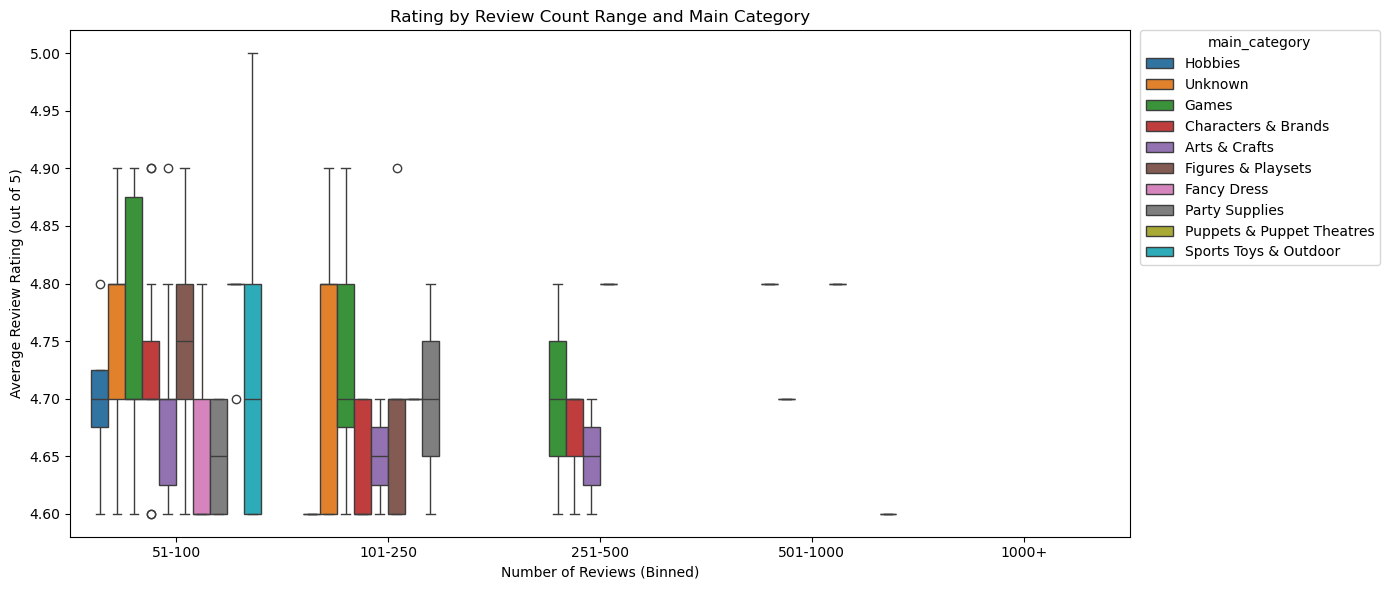

In [ ]:
# When using the scatterplot, the points are too clustered together. Given that there are many different main categories, and the points are overlapping each other, you cannot visualise easily.
# I have also tried using jitter to spread out the points, but it still doesn't look good.
# Then I tried using the violin plot, but it also doesn't look good because the distribution is not very clear.
# Finally, I tried using the boxplot, and it looks good. The distribution is clear.

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_top_filtered,
    x="review_bins",
    y="average_review_rating_out_of_5",
    hue="main_category",
    dodge=True, # This code ensures the review bin gets its own separate box, side by side, not overlapping each other.
    width=0.8)


plt.legend(
    title="main_category",
    bbox_to_anchor=(1.01, 1),  # Place legend outside the axes
    loc='upper left',
    borderaxespad=0) # Space between the legend and the graph


plt.title("Rating by Review Count Range and Main Category")
plt.xlabel("Number of Reviews (Binned)")
plt.ylabel("Average Review Rating (out of 5)")
plt.tight_layout()  # Prevent label/legend cutoff
plt.show()


# Answer to the Research Question
 - I should sell products in the Games category, as most items in this category receive high response rates and optimal ratings.